In [1]:
# https://covidtracking.com
# https://covid19.healthdata.org/projections

import requests
import pandas as pd
import numpy as np
import math
import json
from IPython.display import Markdown as md
from datetime import timedelta
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cufflinks as cf
import qgrid
from pivottablejs import pivot_ui

import os

# Pandas Settings Change
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_seq_items', 14)
pd.DataFrame._repr_html_ = lambda self: self.to_html(escape=False)

def sparkline(data, figsize=(4, 0.25), **kwargs):
    """
    creates a sparkline
    """
    from matplotlib import pyplot as plt
    from IPython import display
    import base64
    from io import BytesIO
 
    data = list(data)
 
    *_, ax = plt.subplots(1, 1, figsize=figsize, **kwargs)
    ax.plot(data)
    ax.fill_between(range(len(data)), data, len(data)*[min(data)], alpha=0.1)
    ax.set_axis_off()
 
    img = BytesIO()
    plt.savefig(img)
    plt.close()
    return '<img src="data:image/png;base64, {}" />'.format(base64.b64encode(img.getvalue()).decode())

  

# Load State Population file
with open('state_populations.json') as data:
    state_pop = pd.read_json(data)

# Load Available State Hospital Beds (above normal annual hospital activity)
with open('state_hospital_beds.json') as data:
    state_beds = pd.read_json(data)
    
# Pull latest data
states = state_pop['state_code'].to_list()

with open('states_history.json') as data:
    all_state_hist = pd.read_json(data)

drop_states = ["PR",
               "AS",
               "GU",
               "MP",
               "VI",
              ]

for state in drop_states:
    state_pop.drop(state_pop[state_pop.state_code == state].index, inplace=True)
    state_beds.drop(state_beds[state_beds.state_code == state].index, inplace=True)
    all_state_hist.drop(all_state_hist[all_state_hist.state == state].index, inplace=True)
    

#states = ["TN"]
#state_df_list = []

drop_columns = ["total",
                "dateChecked",
                "hash",
               ]

all_state_hist.drop(columns=drop_columns, inplace=True)
all_state_hist.fillna(0, inplace=True)
all_state_hist['date'] = pd.to_datetime(all_state_hist['date'], format="%Y%m%d")
#all_state_hist.columns

In [2]:
#all_state_hist.set_index('date', inplace=True)
all_state_hist['positive_14s'] = 0
all_state_hist['totalTestResults_14s'] = 0
for state in states:
    #all_state_hist['positive_14s'] = 0
    #all_state_hist.loc[all_state_hist.state == state, ['positive']].rolling(14).sum().shift(-13)
    state_df = all_state_hist[all_state_hist.state == state]
    state_df['positive_14s'] = state_df['positiveIncrease'].rolling(14).sum().shift(-13)
    state_df['totalTestResults_14s'] = state_df['totalTestResultsIncrease'].rolling(14).sum().shift(-13)
    #state_df_list.append((state, state_df))
    all_state_hist.update(state_df['positive_14s'])
    all_state_hist.update(state_df['totalTestResults_14s'])
    
all_state_hist['pos_rate_14a'] = all_state_hist['positive_14s'].div(all_state_hist['totalTestResults_14s'], fill_value=0)
#all_state_hist.head()

## Rolling 14 Day Sum of Positive Cases

In [3]:
pos_trend = all_state_hist.pivot(index='state', columns='date', values='positive_14s')
pos_trend.fillna(0, inplace=True)
pos_trend['Trend'] = pos_trend.apply(sparkline, axis=1)
pos_trend[pos_trend.columns[-8:]]

date   2020-05-01 00:00:00  2020-05-02 00:00:00  2020-05-03 00:00:00  \
state                                                                  
AK                    55.0                 51.0                 49.0   
AL                  2628.0               2779.0               2888.0   
AR                  1626.0               1633.0               1650.0   
AZ                  3455.0               3645.0               3711.0   
CA                 22914.0              23234.0              23283.0   
CO                  6609.0               6721.0               6792.0   
CT                 11955.0              11955.0              11737.0   
DC                  2182.0               2131.0               2223.0   
DE                  2595.0               2715.0               2670.0   
FL                 10609.0              10194.0              10082.0   
GA                 10076.0              10637.0              10301.0   
HI                    77.0                 66.0                 46.0   
IA                  5552.0               6128.0               6267.0   
ID                   406.0                380.0                393.0   
IL                 28480.0              29345.0              31142.0   
IN                  8476.0               8654.0               8723.0   
KS                  2744.0               2956.0               3181.0   
KY                  2279.0               2357.0               2172.0   
LA                  5593.0               5560.0               5412.0   
MA                 29186.0              28736.0              28267.0   
MD                 11900.0              12165.0              12632.0   
ME                   296.0                305.0                318.0   
MI                 12333.0              12416.0              12330.0   
MN                  3659.0               4015.0               4307.0   
MO                  2552.0               2637.0               2719.0   
MS                  3419.0               3467.0               3276.0   
MT                    31.0                 29.0                 22.0   
NC                  5064.0               5369.0               5171.0   
ND                   668.0                625.0                606.0   
NE                  3215.0               3700.0               4039.0   
NH                   859.0               1023.0               1087.0   
NJ                 42723.0              42297.0              41443.0   
NM                  1814.0               1802.0               1934.0   
NV                  1703.0               1685.0               1698.0   
NY                 78672.0              76245.0              73629.0   
OH                  9636.0               9113.0               8312.0   
OK                  1283.0               1281.0               1373.0   
OR                   794.0                791.0                770.0   
PA                 17530.0              17236.0              16983.0   
RI                  4785.0               4810.0               4722.0   
SC                  2327.0               2243.0               2249.0   
SD                  1114.0               1046.0                996.0   
TN                  5302.0               5899.0               6107.0   
TX                 11858.0              12262.0              12625.0   
UT                  2023.0               2050.0               2106.0   
VA                  9410.0               9678.0              10134.0   
VT                   100.0                 83.0                 85.0   
WA                  2654.0               2750.0               2857.0   
WI                  3269.0               3461.0               3618.0   
WV                   382.0                384.0                328.0   
WY                   263.0                261.0                270.0   

date   2020-05-04 00:00:00  2020-05-05 00:00:00  2020-05-06 00:00:00  \
state                                                                  
AK                    49.0             

## Rolling 14 Day Average of Daily Positive Test Rate

In [4]:
rate_trend = all_state_hist.pivot(index='state', columns='date', values='pos_rate_14a')
rate_trend.fillna(0, inplace=True)
rate_trend['Trend'] = rate_trend.apply(sparkline, axis=1)
rate_trend[rate_trend.columns[-8:]]

date   2020-05-01 00:00:00  2020-05-02 00:00:00  2020-05-03 00:00:00  \
state                                                                  
AK                0.005057             0.004343             0.004194   
AL                0.048590             0.055948             0.061725   
AR                0.062104             0.059509             0.057529   
AZ                0.134703             0.135240             0.131928   
CA                0.056806             0.054395             0.053542   
CO                0.216263             0.199780             0.192408   
CT                0.266882             0.266882             0.265063   
DC                0.256948             0.243933             0.236414   
DE                0.302871             0.298516             0.298558   
FL                0.063201             0.060147             0.058579   
GA                0.104217             0.105744             0.108246   
HI                0.008336             0.006845             0.004852   
IA                0.233277             0.261858             0.218850   
ID                0.031130             0.029501             0.030376   
IL                0.184307             0.180594             0.176948   
IN                0.188969             0.183084             0.182807   
KS                0.170086             0.171204             0.170581   
KY                0.084832             0.087125             0.085431   
LA                0.154230             0.159500             0.132608   
MA                0.212546             0.209962             0.194234   
MD                0.201784             0.202238             0.194629   
ME                0.051335             0.052814             0.054941   
MI                0.134719             0.121747             0.119859   
MN                0.115150             0.115576             0.116670   
MO                0.083105             0.090978             0.093543   
MS                0.103719             0.097088             0.085029   
MT                0.007830             0.007132             0.005354   
NC                0.083220             0.084867             0.079477   
ND                0.038876             0.033631             0.030726   
NE                0.225124             0.236105             0.242045   
NH                0.091960             0.088980             0.072617   
NJ                0.431127             0.423920             0.397047   
NM                0.054342             0.050753             0.050480   
NV                0.123111             0.123570             0.124205   
NY                0.222102             0.210308             0.199885   
OH                0.153979             0.136467             0.132216   
OK                0.042864             0.045556             0.048669   
OR                0.036330             0.035073             0.033455   
PA                0.218920             0.211716             0.207649   
RI                0.133335             0.129601             0.127007   
SC                0.100758             0.098451             0.094862   
SD                0.176797             0.162650             0.156727   
TN                0.053632             0.055814             0.056805   
TX                0.065068             0.059988             0.060741   
UT                0.035624             0.035430             0.035971   
VA                0.163815             0.192923             0.190242   
VT                0.024290             0.020621             0.020104   
WA                0.060960             0.059746             0.053945   
WI                0.097670             0.098691             0.099691   
WV                0.013564             0.012927             0.010377   
WY                0.080477             0.074423             0.091899   

date   2020-05-04 00:00:00  2020-05-05 00:00:00  2020-05-06 00:00:00  \
state                                                                  
AK                0.004225             

## Charts

In [5]:
rate_trend.drop(columns="Trend", inplace=True)

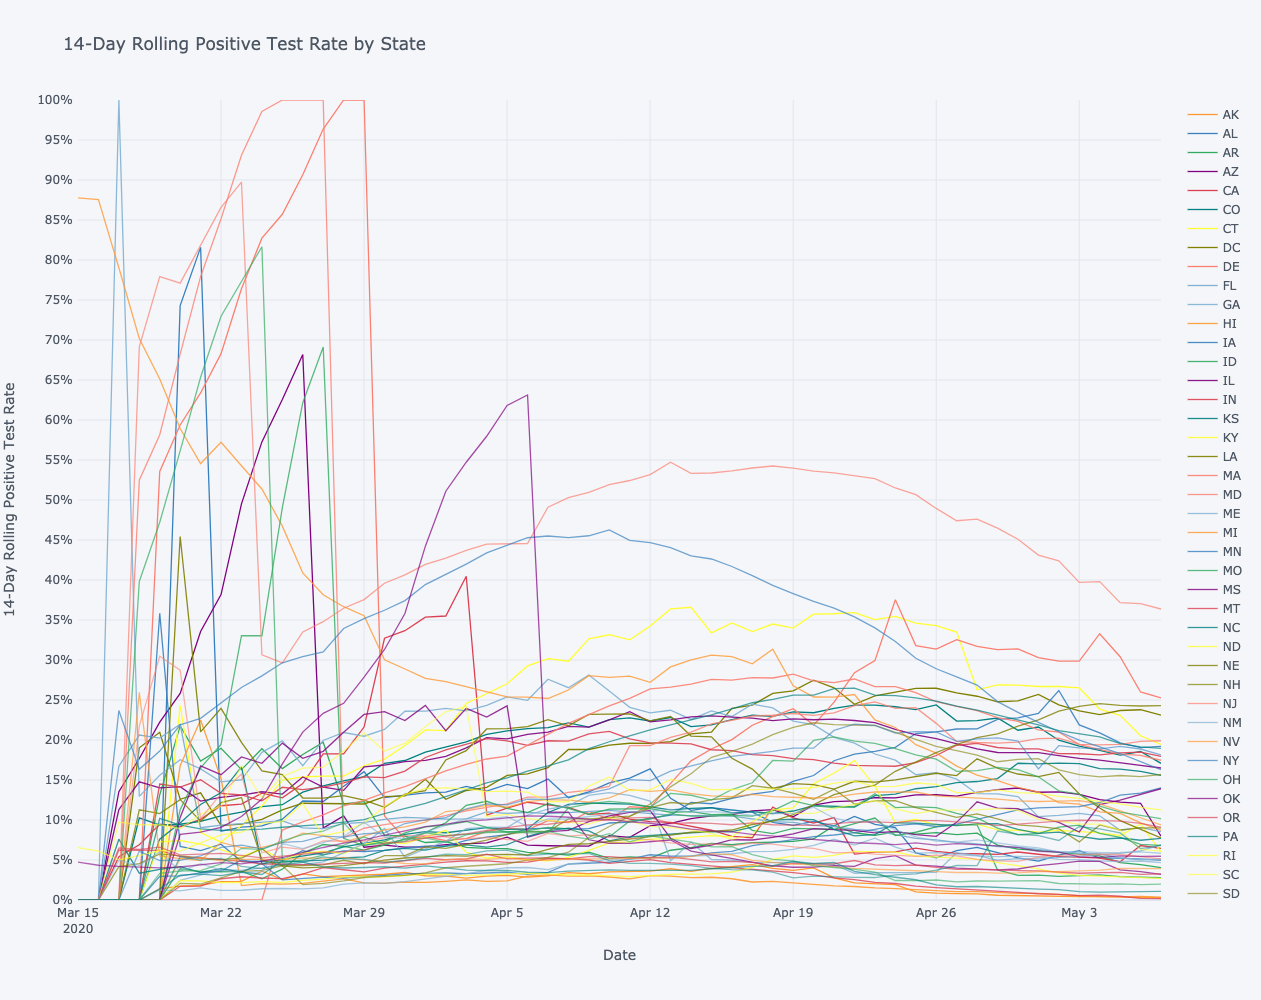

In [6]:
#covid_sort = covid.sort_values(by='positiveShareDelta', ascending=False)
#covid_sort['polarity'] = covid_sort['positiveShareDelta'] < 0
#colors = []
#for polarity in covid_sort.polarity.values:
#    if polarity:
#        colors.append("green")
#    else:
#        colors.append("red")
#fig = go.Figure()
#fig.add_trace(go.line(x=covid_sort.state, y=covid_sort.positiveShareDelta, marker_color=colors))
#fig.layout.xaxis.tickfont.size = 8
#fig.layout.yaxis.tickformat = '0.0%'
#fig.update_layout(title_text='Share of Positive Tests vs Share of Population Delta')
#fig.update_layout(
#    autosize=False,
#    width=800,
#    height=800,
#    margin=dict(
#        l=50,
#        r=50,
#        b=100,
#        t=100,
#        pad=4
#    ),
#)

#rate_trend.drop(columns="Trend", inplace=True)
line_graph = all_state_hist.pivot(index='date', columns='state', values='pos_rate_14a')
line_graph.fillna(0, inplace=True)
#line_graph.head()
#all_state_hist[['state', 'pos_rate_14a']].groupby(["state"]).head()

fig = line_graph.loc['2020-03-15':].iplot(asFigure=True, xTitle="Date", yTitle="14-Day Rolling Positive Test Rate", title="14-Day Rolling Positive Test Rate by State")
fig.layout.yaxis.tickformat = '0.0%'
fig.update_yaxes(range=[0,1], dtick=0.05)
fig.update_layout(
    autosize=False,
    width=1200,
    height=1000,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
)
fig.show()

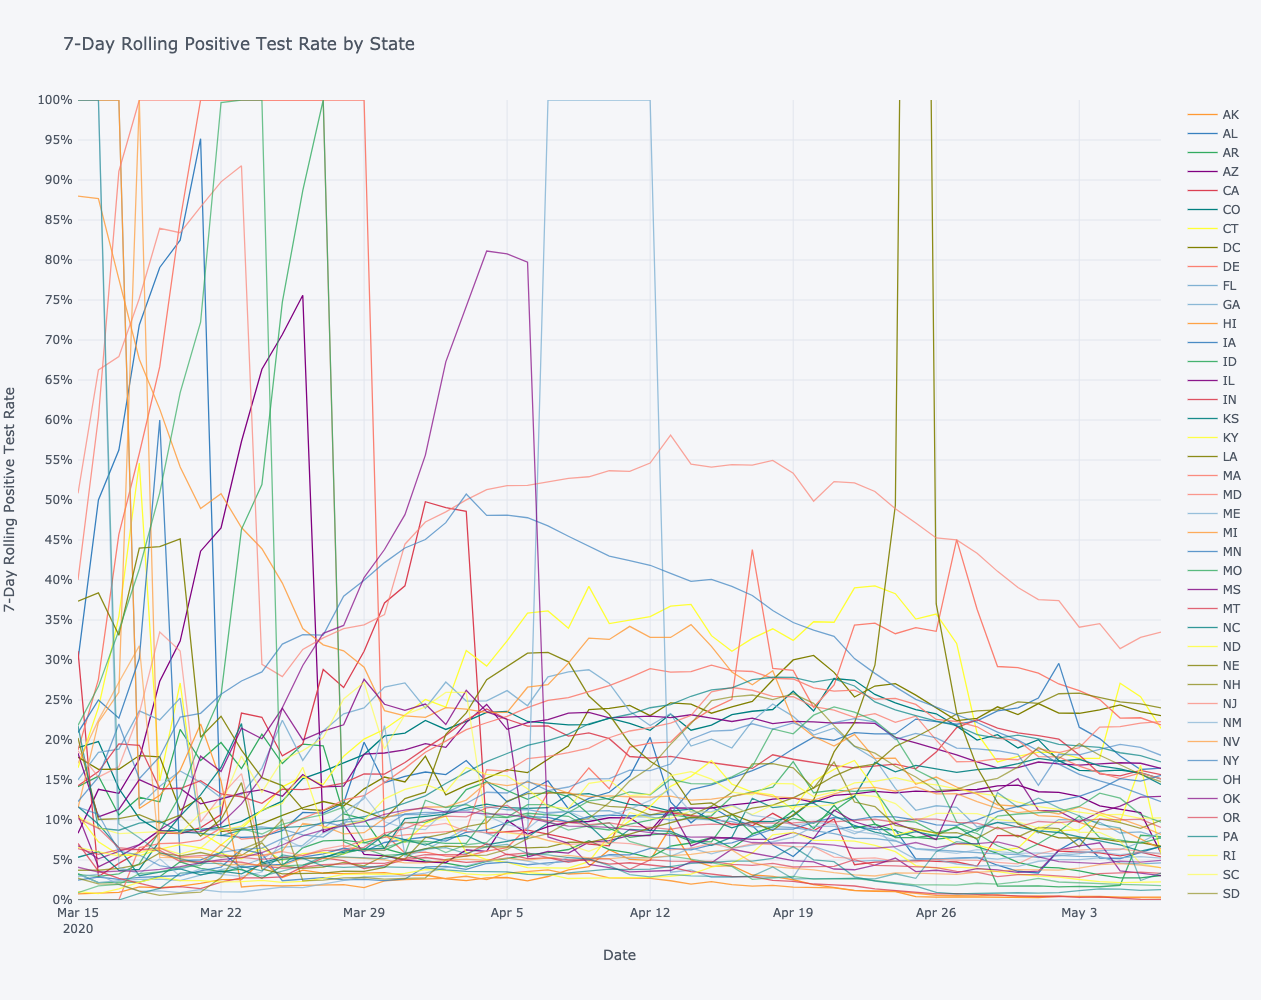

In [7]:
#all_state_hist.set_index('date', inplace=True)
all_state_hist['positive_7s'] = 0
all_state_hist['totalTestResults_7s'] = 0
for state in states:
    #all_state_hist['positive_14s'] = 0
    #all_state_hist.loc[all_state_hist.state == state, ['positive']].rolling(14).sum().shift(-13)
    state_df = all_state_hist[all_state_hist.state == state]
    state_df['positive_7s'] = state_df['positiveIncrease'].rolling(7).sum().shift(-6)
    state_df['totalTestResults_7s'] = state_df['totalTestResultsIncrease'].rolling(7).sum().shift(-6)
    #state_df_list.append((state, state_df))
    all_state_hist.update(state_df['positive_7s'])
    all_state_hist.update(state_df['totalTestResults_7s'])
    
all_state_hist['pos_rate_7a'] = all_state_hist['positive_7s'].div(all_state_hist['totalTestResults_7s'], fill_value=0)
#all_state_hist.head()
line_graph = all_state_hist.pivot(index='date', columns='state', values='pos_rate_7a')
line_graph.fillna(0, inplace=True)
#line_graph.head()
#all_state_hist[['state', 'pos_rate_14a']].groupby(["state"]).head()

fig = line_graph.loc['2020-03-15':].iplot(asFigure=True, xTitle="Date", yTitle="7-Day Rolling Positive Test Rate", title="7-Day Rolling Positive Test Rate by State")
fig.layout.yaxis.tickformat = '0.0%'
fig.update_yaxes(range=[0,1], dtick=0.05)
fig.update_layout(
    autosize=False,
    width=1200,
    height=1000,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
)
fig.show()